In [185]:
import pandas as pd
import numpy as np
import time
import pylab as pl
import math
import os
import pickle
import gzip
from operator import itemgetter
from matplotlib import collections  as mc
import copy
from random import randint

In [186]:
def save_in_file_fast(arr, file_name):
    pickle.dump(arr, open(file_name, 'wb'))


def load_from_file_fast(file_name):
    return pickle.load(open(file_name, 'rb'))


def SieveOfEratosthenes(n):
    # Create a boolean array "prime[0..n]" and initialize
    #  all entries it as true. A value in prime[i] will
    # finally be false if i is Not a prime, else true.
    prime = [True for i in range(n + 1)]
    p = 2
    while (p * p <= n):

        # If prime[p] is not changed, then it is a prime
        if (prime[p] == True):

            # Update all multiples of p
            for i in range(p * 2, n + 1, p):
                prime[i] = False
        p += 1
    return prime

In [187]:
def get_primes():
    cache_path = OUTPUT_PATH + 'prime_list.pkl'
    if not os.path.isfile(cache_path):
        n = 200000
        prime = SieveOfEratosthenes(n)
        plist = []
        for p in range(2, n):
            if prime[p]:
                plist.append(p)
        save_in_file_fast(set(plist), cache_path)
    else:
        plist = load_from_file_fast(cache_path)

    return plist

In [188]:
# Globals
INPUT_PATH = 'input/'
OUTPUT_PATH = './'
CITIES = pd.read_csv('input/cities.csv')
PRIMES = get_primes()

all_ids = CITIES['CityId'].values
all_x = CITIES['X'].values
all_y = CITIES['Y'].values

CITIES_HASH = dict()
for i, id in enumerate(all_ids):
    CITIES_HASH[id] = (all_x[i], all_y[i])

In [189]:
def isPrime(num):
    return num in PRIMES

In [190]:
# return a list of original submission, before optimization
def get_original_submission():
    return pd.read_csv(INPUT_PATH + 'submission.csv')['Path'].values

In [191]:
ORIGINAL = pd.read_csv('submission.csv')['Path'].values

In [192]:
ORIGINAL

array([     0,  48816,  40230, ..., 177242,  47239,      0])

In [193]:
def get_complete_score(tour):

    score = 0.0
    for i in range(0, len(tour)-1):
        p1 = CITIES_HASH[tour[i]]
        p2 = CITIES_HASH[tour[i+1]]
        stepSize = math.sqrt((p1[0] - p2[0]) * (p1[0] - p2[0]) + (p1[1] - p2[1]) * (p1[1] - p2[1]))
        if ((i + 1) % 10 == 0) and (tour[i] not in PRIMES):
            stepSize *= 1.1
        score += stepSize
    return score

In [194]:
print(get_complete_score(ORIGINAL))

1533207.6131170895


In [195]:
# 
def get_score(tour, start, end):
    score = 0.0
    for i in range(start, end):
        p1 = CITIES_HASH[tour[i]]
        p2 = CITIES_HASH[tour[i+1]]
        stepSize = math.sqrt((p1[0] - p2[0]) * (p1[0] - p2[0]) + (p1[1] - p2[1]) * (p1[1] - p2[1]))
        if ((i + 1) % 10 == 0) and (tour[i] not in PRIMES):
            stepSize *= 1.1
        score += stepSize
    return score

In [198]:
def swap(arr, i, j):
    temp = arr[i]
    arr[i] = arr[j]
    arr[j] = temp

In [199]:
def swap_if_better(tour, i, j):
    # consider to swap if it is not start or end or equal
    if i != j and i != 0 and j != 0 and i != len(ORIGINAL - 1) and j != len(ORIGINAL - 1):
        original_score = 0
        swap_score = 0
        # if swap next to each other
        if (abs(i - j) == 1):
            # three segments
            original_score = get_score(tour, i - 1, j + 1)
            swap(tour, i, j)
            swap_score = get_score(tour, i - 1, j + 1)
        else:
            original_score = get_score(tour, i - 1, i + 1) + get_score(tour, j - 1, j + 1)
            swap(tour, i, j)
            swap_score = get_score(tour, i - 1, i + 1) + get_score(tour, j - 1, j + 1)
        # swap back if there is no improvement
        if swap_score >= original_score:
            swap(tour, i, j)
        


In [200]:
def score_diff_if_swap(tour, i, j):
    if i == j or i == 0 or j == 0 or i == len(ORIGINAL - 1) or j == len(ORIGINAL - 1):
        return 0
    else:
        original_score = 0
        swap_score = 0
        # if swap next to each other
        if (abs(i - j) == 1):
            # three segments
            original_score = get_score(tour, i - 1, j + 1)
            swap(tour, i, j)
            swap_score = get_score(tour, i - 1, j + 1)
        else:
            original_score = get_score(tour, i - 1, i + 1) + get_score(tour, j - 1, j + 1)
            swap(tour, i, j)
            swap_score = get_score(tour, i - 1, i + 1) + get_score(tour, j - 1, j + 1)
        swap(tour, i, j)
        return swap_score - original_score

In [202]:
def save_to_csv(arr):
    sub = pd.DataFrame(np.array(arr), columns = ["Path"])
    sub.to_csv('submission.csv', index=None)

In [204]:
def optimization2():
    numIter = 50000000
    modified = copy.deepcopy(ORIGINAL)
    total_reduction = 0.0
    last_saved_reduction = 0.0
    for iteration in range(numIter):
        # save every 1000 iterations
        if iteration % 1000 == 0 and last_saved_reduction > total_reduction:
            last_saved_reduction = total_reduction
            print(iteration)
            print("saving to csv")
            print("total reduction so far: " + str(total_reduction))
            save_to_csv(modified)
            print("score so far: " + str(get_complete_score(modified)))
        step = randint(10, len(ORIGINAL) - 1)
        best_reduction = 0
        for i in range(-10, 10):
            index = step + i
            if (index < len(ORIGINAL) and index > 0):
                start = min(step, index) - 1
                end = min(max(step, index) + 1, len(ORIGINAL) - 1)
                original_score = get_score(modified, start, end)
                swap(modified, step, index)
                modified_score = get_score(modified, start, end)
                score_diff = modified_score - original_score
                if score_diff < best_reduction:
                    best_reduction = score_diff
                    best_swap = [step, index]
                # swap back
                swap(modified,  step, index)
        if (best_reduction < 0):
            swap(modified, best_swap[0], best_swap[1])
            total_reduction += best_reduction
    return modified, total_reduction

In [ ]:
naive_modified2, total_reduction = optimization2()
print("naive optimization")
print(total_reduction)

In [167]:
print(get_complete_score(naive_modified2))

1533208.446566929


In [170]:
lines = [[(CITIES.X[naive_modified2[i]],CITIES.Y[naive_modified2[i]]),(CITIES.X[naive_modified2[i+1]],CITIES.Y[naive_modified2[i+1]])] for i in range(0,len(cities)-1)]
lc = mc.LineCollection(lines, linewidths=2)
fig, ax = pl.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.add_collection(lc)
ax.autoscale()

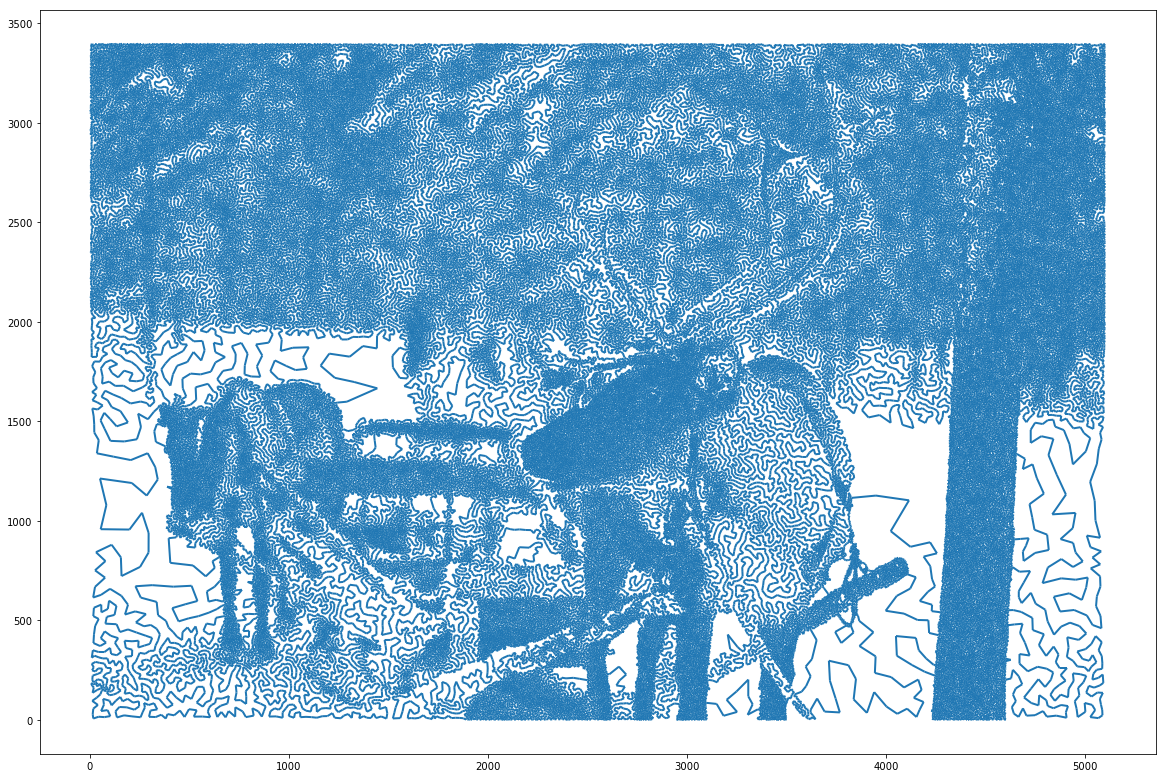

In [171]:
fig

In [168]:
sub = pd.DataFrame(np.array(naive_modified2), columns = ["Path"])

In [169]:
sub.to_csv('submission.csv', index=None)